https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

https://www.kaggle.com/ogrellier/lighgbm-with-selected-features

In [81]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [82]:
POS_CASH_balance = pd.read_pickle('../home credit/POS_CASH_balance.pickle')
bureau_balance = pd.read_pickle('../home credit/bureau_balance.pickle')
application_train = pd.read_pickle('../home credit/application_train.pickle')
previous_application = pd.read_pickle('../home credit/previous_application.pickle')
installments_payments = pd.read_pickle('../home credit/installments_payments.pickle')
credit_card_balance = pd.read_pickle('../home credit/credit_card_balance.pickle')
application_test = pd.read_pickle('../home credit/application_test.pickle')
bureau = pd.read_pickle('../home credit/bureau.pickle')
description = pd.read_csv('../home credit/HomeCredit_columns_description.csv', index_col=0).iloc[:,0:5]
pd.options.display.max_colwidth = 20000
def search_description(column):
    return description.loc[description.Row == column][['Description','日本語訳']]

In [83]:
df = application_train
test_df = application_test
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()
df = df[df['CODE_GENDER'] != 'XNA']

Train samples: 307511, test samples: 48744


In [84]:
docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
len(docs),len(live)

(20, 8)

In [85]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

In [86]:
df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

C:\Users\koyo\anaconda3\lib\site-packages\pandas\core\nanops.py:116: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


In [87]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [88]:
df.shape

(356251, 143)

In [89]:
df['app EXT_SOURCE mean'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
df['MANY_CHILDREN'] = (df["CNT_CHILDREN"] > 5) * 1
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

C:\Users\koyo\anaconda3\lib\site-packages\pandas\core\nanops.py:116: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


In [90]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [91]:
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
df, cat_cols = one_hot_encoder(df)

In [102]:
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]

In [124]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()].reset_index()
train_y = train_df['TARGET']
train_df.drop(['index', 'TARGET'], axis=1, inplace=True)
test_df.drop(['TARGET','index', 'level_0'], axis=1, inplace=True)
train_df.shape, test_df.shape

C:\Users\koyo\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


((307507, 284), (48744, 284))

In [125]:
test_df

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone__brick,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,100001,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018845,...,0,0,0,0,1,0,0,1,0,0
1,100005,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035797,...,0,0,0,0,0,0,1,0,0,1
2,100013,0,1,0,0,202500.0,663264.0,69777.0,630000.0,0.019104,...,0,0,0,0,0,0,1,0,0,1
3,100028,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0.026398,...,0,0,0,1,0,0,0,1,0,0
4,100038,0,1,1,1,180000.0,625500.0,32067.0,625500.0,0.010033,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,1,0,0,0,121500.0,412560.0,17473.5,270000.0,0.002043,...,0,0,0,0,0,0,1,0,0,1
48740,456222,1,0,1,2,157500.0,622413.0,31909.5,495000.0,0.035797,...,0,0,0,0,0,0,1,0,0,1
48741,456223,1,1,0,1,202500.0,315000.0,33205.5,315000.0,0.026398,...,0,0,0,0,1,0,0,1,0,0
48742,456224,0,0,1,0,225000.0,450000.0,25128.0,450000.0,0.018845,...,0,0,0,1,0,0,0,1,0,0


In [126]:
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_indexes = []
    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=6785)
    
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x, train_y)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        tr_x, tr_y = sampler.fit_resample(tr_x, tr_y)
        
        model.fit(tr_x, tr_y, 
                  eval_set= [(tr_x, tr_y), (va_x, va_y)],
                  eval_metric='auc',
                  verbose=200, 
                  early_stopping_rounds=20)
        
        
        tr_pred = model.predict(tr_x)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict_proba(test_x)
        preds_test.append(pred_test)
        va_indexes.append(va_idx)
        print('  score Train : {:.6f}' .format(np.sqrt(roc_auc_score(tr_y, tr_pred))), 
              '  score Valid : {:.6f}' .format(np.sqrt(roc_auc_score(va_y, pred)))) 
        
    # バリデーションデータに対する予測値を連結し、その後元の順番に並べなおす
    va_indexes = np.concatenate(va_indexes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_indexes)
    pred_train = pd.DataFrame(preds[order])
    
    
    # テストデータに対する予測値の平均をとる
    preds_test = pd.DataFrame(np.mean(preds_test, axis=0))
    print('Score : {:.6f}' .format(np.sqrt(roc_auc_score(train_y, pred_train))))
    return pred_train, preds_test, model

In [127]:
model = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.1, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
pred_train, preds_test, lgbm = predict_cv(model, train_df, train_y, test_df)
print('Metrics')
print(metrics)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	training's auc: 0.821424	training's binary_logloss: 0.525649	valid_1's auc: 0.763907	valid_1's binary_logloss: 0.5804
  score Train : 0.860530   score Valid : 0.833812
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[116]	training's auc: 0.831859	training's binary_logloss: 0.515532	valid_1's auc: 0.758729	valid_1's binary_logloss: 0.581953
  score Train : 0.865133   score Valid : 0.827872
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[112]	training's auc: 0.830673	training's binary_logloss: 0.517107	valid_1's auc: 0.763667	valid_1's binary_logloss: 0.580305
  score Train : 0.864137   score Valid : 0.834031
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[99]	training's auc: 0.824611	training's binary_logloss: 0.522949	valid_1's auc: 0.768274	v

In [128]:
sub = test_df[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test.iloc[:, 1]
sub.to_csv('sub.csv', index= False)
# 0.76237

In [ ]:
lgb.plot_impor

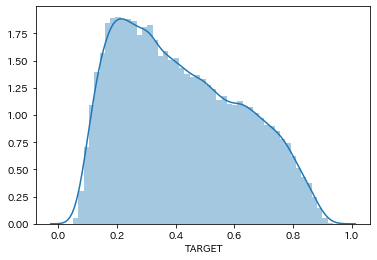

In [130]:
sns.distplot(sub['TARGET'])